2024-07-08 03:08:36.805 | INFO     | taxi.utils.utils:read_yaml:29 - yaml file: config.yaml loaded successfully
2024-07-08 03:08:36.811 | INFO     | taxi.utils.utils:read_yaml:29 - yaml file: params.yaml loaded successfully


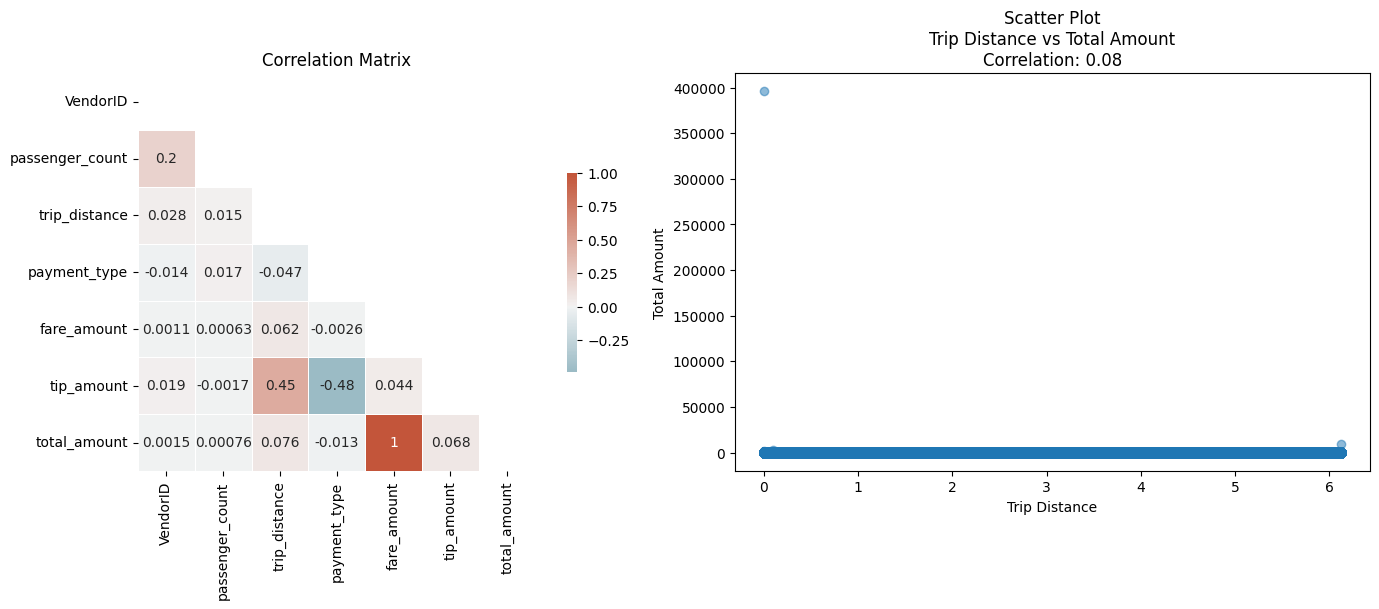

In [2]:
%run ./Preprocessing.ipynb

In [3]:
from sklearn.ensemble import RandomForestRegressor as skRFR
from sklearn.linear_model import LinearRegression as skLR
from sklearn.ensemble import GradientBoostingRegressor as skXGR
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold,cross_val_score, cross_validate
from sklearn.metrics import root_mean_squared_error, recall_score, precision_score, accuracy_score,f1_score,confusion_matrix, r2_score
import pickle
import os

In [8]:
class Model:
  def __init__(self, config,params, x__train, y__train, x__test, y__test ) -> None:
    self.config  = config
    self.params  = params
    self.X_train = x__train
    self.y_train = y__train
    self.X_test = x__test
    self.y_test = y__test
  def linear_regression_model(self):
    params = self.params.Models.LinearRegressionModel.HYPERPARAMETERS
    self.model = skLR(**params)
  def random_forest_regression_model(self):
    params = self.params.Models.RandomForestModel.HYPERPARAMETERS
    self.model = skRFR(**params)
  def gradient_boost_regression(self):
    params = self.params.Models.XGBoostModel.HYPERPARAMETERS
    self.model = skXGR(**params)
  def training(self, folds= 3):
    kf = KFold(folds)
    kf.get_n_splits(self.X_train)
    score = 0.0
    models = []
    for trainIdx, validIdx in kf.split(self.X_train):
        X_train_valid, X_valid = self.X_train.iloc[trainIdx], self.X_train.iloc[validIdx]
        y_train_valid, y_test_valid = self.y_train[trainIdx], self.y_train[validIdx]
        self.model.fit(X_train_valid, y_train_valid)
        score = self.model.score(X_valid, y_test_valid)
        print("score = ", score)
        models.append(self.model)
    return models
  def evaluation(self, estimators):
    estimator_idx=0
    best_estimator_rmse = float('inf')
    for estimator in estimators:
        estimator_idx = estimator_idx+1
        y_test_pred = estimator.predict(self.X_test)
        rmse = root_mean_squared_error(self.y_test, y_test_pred)
        
        if rmse < best_estimator_rmse:
          best_estimator_rmse = rmse
          best_model = estimator
        print("\nestimator_idx: {}, current_estimator_rmse: {},best_estimator_rmse: {}".format(estimator_idx,rmse,best_estimator_rmse))
    
    print(f"Best RMSE: {best_estimator_rmse:.4f}, R2_score: {r2_score(self.y_test, best_model.predict(self.X_test)):.4f}")
        
    return best_model
  def save_model(self,model_path, model_file):
    if not os.path.exists(f'{model_path}'): 
      os.makedirs(f'{model_path}',exist_ok=True)
      with open(model_path+"/"+model_file, 'wb') as file:
        pickle.dump(self.model, file)

In [9]:
model_obj = Model(config=CONFIG, params=PARAMS, x__train=X_train[:100000],y__train=y_train[:100000], x__test=X_test,y__test=y_test )


In [10]:
model_obj.random_forest_regression_model()
estimators = model_obj.training()
best_model = model_obj.evaluation(estimators)
model_obj.save_model(model_path=f'{CONFIG.Model.MODEL_PATH}/{CONFIG.Model.RF_MODEL}/',model_file=f'{CONFIG.Model.MODEL_FILE}')

score =  0.5314118898971403
score =  0.5189573041214726
score =  0.49007904141945213

estimator_idx: 1, current_estimator_rmse: 39.68285071155763,best_estimator_rmse: 39.68285071155763

estimator_idx: 2, current_estimator_rmse: 39.68285071155763,best_estimator_rmse: 39.68285071155763

estimator_idx: 3, current_estimator_rmse: 39.68285071155763,best_estimator_rmse: 39.68285071155763
Best RMSE: 39.6829, R2_score: 0.0008


In [11]:
model_obj.gradient_boost_regression()
estimators = model_obj.training()
best_model = model_obj.evaluation(estimators)
model_obj.save_model(model_path=f'{CONFIG.Model.MODEL_PATH}/{CONFIG.Model.XGBoost_MODEL}/',model_file=f'{CONFIG.Model.MODEL_FILE}')


score =  0.5315133303622104
score =  0.5212792965065418
score =  0.4905370278587723

estimator_idx: 1, current_estimator_rmse: 39.682797169027985,best_estimator_rmse: 39.682797169027985

estimator_idx: 2, current_estimator_rmse: 39.682797169027985,best_estimator_rmse: 39.682797169027985

estimator_idx: 3, current_estimator_rmse: 39.682797169027985,best_estimator_rmse: 39.682797169027985
Best RMSE: 39.6828, R2_score: 0.0008
